In [1]:
%%capture
!pip install wandb
!pip install tensorflow

In [1]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: steffitlw (use `wandb login --relogin` to force relogin)


True

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from wandb.keras import WandbCallback

In [3]:
arr = np.eye(200)
arr.shape

(200, 200)

In [4]:
arr[:-36, :-36][36:, 36:].shape

(128, 128)

In [5]:
import os
import tqdm as tqdm
sample_size = 10369
training_dataset_x = np.zeros((sample_size, 10, 128, 128))
training_dataset_y = np.zeros((sample_size, 128, 128))

for i, filename in tqdm(enumerate(os.listdir('u_arr'))):
    load_arr = np.load('u_arr/' + filename)
    if len(load_arr) == 10:
        new_arr = [arr[:-36, :-36][36:, 36:] for arr in load_arr]
    else:
        new_arr = [arr[:-36, :-36][36:, 36:] for arr in load_arr[1:]]
    training_dataset_x[i] = new_arr
    split_filename = filename.split('data')[1].split('_')[0]
    training_dataset_y[i] = np.load('local_parameter_arrays/a' + split_filename + '.npy')[:-36, :-36][36:, 36:]

np.save('training_dataset_x', training_dataset_x)
np.save('training_dataset_y', training_dataset_y)

TypeError: 'module' object is not callable

In [ ]:
a =np.load('training_dataset_x.npy')

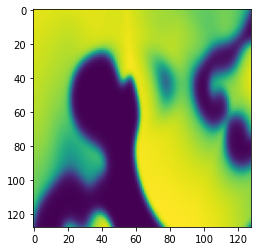

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(a[1][8])

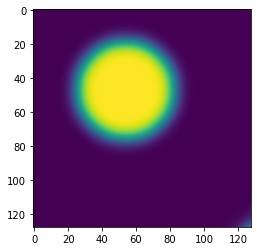

In [ ]:
b =np.load('training_dataset_y.npy')

In [6]:
plt.imshow(b[1])

NameError: name 'plt' is not defined

In [7]:
x_train.shape

NameError: name 'x_train' is not defined

In [10]:
batch_size = 32
epochs = 10
validation_split = 0.05

x_train = np.load('training_dataset_x.npy', mmap_mode='r')[0:10000]
x_train = np.moveaxis(x_train, 1, -1)
y_train = np.load('training_dataset_y.npy', mmap_mode='r')[0:10000]
input_shape = x_train[0].shape

wandb.init(project="2d-het-project")


def encoder_decoder_model(input_shape, activation='relu', last_activation='relu',
                          encoder_filters=(32, 64, 128),
                          decoder_filters=(128, 64, 32),
                          output_dims=1):
    inp = layers.Input(input_shape)
    x = inp
    for filters in encoder_filters:
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(encoder_filters[-1] * 2, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    for filters in decoder_filters:
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
    x = layers.Conv2D(output_dims, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    decoded = layers.Activation(last_activation)(x)

    model = Model(inputs=[inp], outputs=[decoded])
    return model


model = encoder_decoder_model(input_shape)
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    callbacks=[WandbCallback()])

model.save('model.h5')

# Evaluate test data
# x_test = np.load('test_dataset_x.npy', mmap_mode='r')
# y_test = np.load('test_dataset_y.npy', mmap_mode='r')

# prediction = model.predict(x_test)

# compute error metrics etc ...


accuracy,█▁▁▁▁▁▃▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
mae,█▂▂▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▅▆▅▃▃▁▁
val_mae,█▇▆▄▄▃▂▂▁▁
accuracy,1e-05
best_epoch,9
best_val_loss,0.01268
epoch,9


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 10)]    0         
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 32)      2912      
                                                                 
 batch_normalization_16 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 64)        1849

2022-03-15 16:54:37.900904: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6225920000 exceeds 10% of free system memory.
2022-03-15 16:54:49.995135: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.80GiB (rounded to 6225920000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-03-15 16:54:49.995163: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-03-15 16:54:49.995178: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 148, Chunks in use: 148. 37.0KiB allocated for chunks. 37.0KiB in use in bin. 16.0KiB client-requested in use in bin.
2022-03-15 16:54:49.995188: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunk

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

c:1066] InUse at 7f534e001600 of size 256 next 23
2022-03-15 16:54:49.995438: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f534e001700 of size 512 next 24
2022-03-15 16:54:49.995444: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f534e001900 of size 512 next 27
2022-03-15 16:54:49.995448: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f534e001b00 of size 512 next 28
2022-03-15 16:54:49.995453: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f534e001d00 of size 512 next 29
2022-03-15 16:54:49.995458: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f534e001f00 of size 512 next 30
2022-03-15 16:54:49.995462: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f534e002100 of size 256 next 31
2022-03-15 16:54:49.995467: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f534e002200 of size 256 next 32
2022-03-15 16:54:49.995472: I tensorflow/core/common_runtime/bfc_all

In [1]:
history

history
